In [43]:
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pertpy as pt
import warnings
from matplotlib import rcParams
from gprofiler import GProfiler
from tqdm import tqdm
import torch
from pathlib import Path 


rcParams['figure.dpi'] = 100
FIGSIZE=(3,3)               
rcParams['figure.figsize']=FIGSIZE

**Util functions**

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
import seaborn as sns

def plot_umap_with_compound_and_batch(adata, compound_category='compound', batch_category='batch', target_compound='UNTREATED', dim_red="umap"):
    """
    Plot UMAP with points colored based on compound category and batch.
    
    Parameters:
        adata (Anndata): Annotated data object containing precomputed UMAP coordinates.
        compound_category (str): Name of the compound category column in adata.obs.
        batch_category (str): Name of the batch category column in adata.obs.
        target_compound (str): Compound to highlight, others will be grey.
    """
    # Create color palette based on unique combinations of compound and batch
    unique_combinations = adata.obs[[compound_category, batch_category]].drop_duplicates()
    unique_combinations = unique_combinations.loc[unique_combinations[compound_category]==target_compound].sort_values(by="batch")
    palette = sns.color_palette("colorblind", n_colors=len(unique_combinations))
    colors = dict(zip(unique_combinations.apply(tuple, axis=1), palette))

    # Plot all points in grey
    np.random.seed(13)
    plt.figure(figsize=(3,3))
    plt.scatter(adata.obsm[f'X_{dim_red}'][:, 0], adata.obsm[f'X_{dim_red}'][:, 1], color='grey', alpha=0.5, label='Other', s=5)
    
    # Plot points colored by compound and batch
    for idx, (compound, batch) in enumerate(unique_combinations.values):
        indices = (adata.obs[compound_category] == compound) & (adata.obs[batch_category] == batch)
        print(indices.sum())
        if compound == target_compound:
            plt.scatter(adata.obsm[f'X_{dim_red}'][indices, 0], adata.obsm[f'X_{dim_red}'][indices, 1], 
                        color=colors[(compound, batch)], label=f'{compound} batch {batch.replace("0","")}', s=8)

    print()
    plt.title(f'UMAP colored by {compound_category} and {batch_category}')
    plt.xlabel(f'{dim_red} 1')
    plt.ylabel(f'{dim_red} 2')
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.show()

def differentially_enriched_paths(clus1, clus2):
    clus1 = clus1.set_index("name")
    clus2 = clus2.set_index("name")
    intersected = np.intersect1d(clus1.index, clus2.index)
    diff = np.setdiff1d(clus1.index, clus2.index)
    clus1_intersected = clus1.loc[intersected]
    clus2_intersected = clus2.loc[intersected]
    return -np.log10(clus1_intersected["p_value"]/clus2_intersected["p_value"]).sort_values(), diff

**Read data**

In [45]:
path_before_correction = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/dino_featurization_project/featurized_anndata/rxrx1/rxrx1_adata_before_transf.h5ad" 
path_after_correction = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/dino_featurization_project/featurized_anndata/rxrx1/rxrx1_adata_after_transf_stargan.h5ad"

In [46]:
adata_before_correction = sc.read_h5ad(path_before_correction)
adata_after_correction = sc.read_h5ad(path_after_correction)

In [47]:
sc.pp.neighbors(adata_after_correction)

In [48]:
data_index = pd.read_csv('/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/rxrx1/metadata/rxrx1_df.csv', index_col=1)
compound_names = []

for row in adata_before_correction.obs.iterrows():
    batch = row[1].batch
    plate = row[1].plate
    well = row[1].well
    view = row[1]["view"]
    no = row[1].no
    file_name = f"U2OS-{batch}_{plate}_{well}_{view}_{no}"
    cpd = data_index.loc[file_name].CPD_NAME
    compound_names.append(cpd)
    
adata_before_correction.obs["compound"] = compound_names

compound_names = []
for row in adata_after_correction.obs.iterrows():
    batch = row[1].batch
    plate = row[1].plate
    well = row[1].well
    view = row[1]["view"]
    no = row[1].no
    file_name = f"U2OS-{batch}_{plate}_{well}_{view}_{no}"
    cpd = data_index.loc[file_name].CPD_NAME
    compound_names.append(cpd)
    
adata_after_correction.obs["compound"] = compound_names

Original

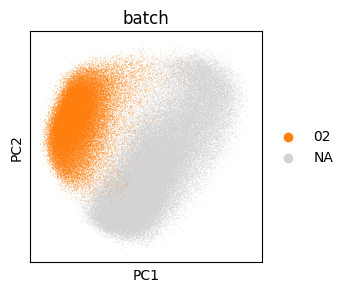

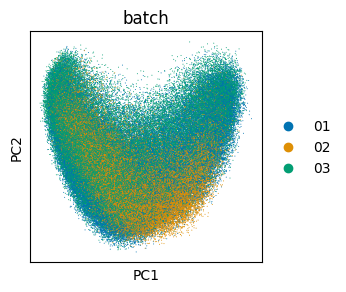

In [49]:
sc.pl.pca(adata_before_correction, color="batch", groups="02")
sc.pl.pca(adata_after_correction, color="batch", size=2)

In [50]:
for i in np.unique(data_index.CPD_NAME):
    print(i)

A4GALT
A4GNT
ABCA7
ABCA9
ABCC4
ABHD1
ABHD11
ABHD14B
ABI1
ABI3
ABLIM2
ACAA2
ACAD10
ACCS
ACOT2
ACSBG2
ACSS1
ACTL7B
ACTR5
ACTRT3
ADAP1
ADIPOR1
AGBL2
AGBL4
AGMAT
AGPAT2
AGR2
AHCYL1
AHSA1
AKAP3
AKAP9
AKR1A1
AKR1E2
ALDH1L1
ALG3
ALG9
ALYREF
AMDHD2
AMMECR1
ANAPC10
ANAPC11
ANAPC7
ANGPT4
ANGPTL4
ANGPTL6
ANKIB1
ANTXR1
AP5Z1
APC2
APH1A
APH1B
APIP
APOBEC2
APOL3
APOL4
APOL5
APPBP2
APTX
AREL1
ARFGAP2
ARHGAP10
ARHGAP11A
ARHGAP25
ARID3B
ARIH2
ARL14
ARL15
ARL6
ARL6IP5
ARMCX2
ARPC1A
ARPC5L
ARSJ
ASAP1
ASCC1
ASCC3
ASPN
ATF7
ATG13
ATG7
ATL1
ATP2C1
ATP5H
ATP6AP2
ATP6V0A4
ATP6V1H
ATP8A2
ATP8B4
AZIN1
B3GALT5
B3GNT2
B3GNT3
BAIAP2
BASP1
BCAS2
BCL11A
BCL7B
BCO2
BICC1
BLM
BMS1
BNC2
BPIFA1
BRD8
BRIP1
BTBD1
BTBD10
BTN2A3P
BTN3A3
BTNL3
BZW1
C14orf2
C1D
C1orf61
C2CD2L
C2CD5
CALCOCO2
CALY
CAP1
CAP2
CARD11
CARD6
CARM1
CARTPT
CBLL1
CBR4
CBX1
CCL26
CCL27
CCNI
CCNO
CCP110
CD244
CD2BP2
CD83
CDADC1
CDC42EP2
CDHR2
CDHR5
CDIPT
CDK2AP2
CDON
CECR1
CELF1
CEP104
CEP57
CEPT1
CFDP1
CFTR
CHAF1A
CHD9
CHERP
CHL1
CHMP6
CHPF2
CHRAC1
CHST

# CONTROLS

200
200
200



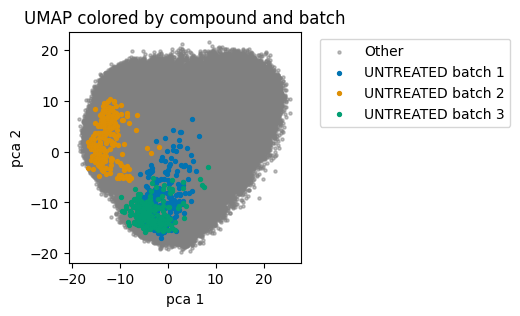

In [51]:
plot_umap_with_compound_and_batch(adata_before_correction, "compound", "batch", "UNTREATED", dim_red="pca")

200
200
200



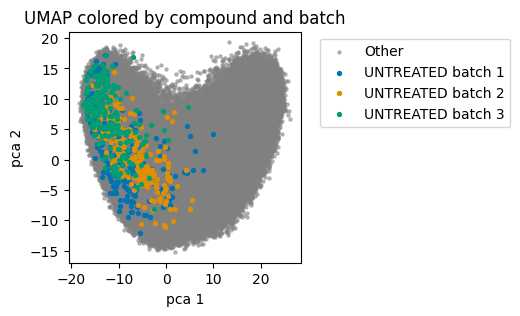

In [52]:
plot_umap_with_compound_and_batch(adata_after_correction, "compound", "batch", "UNTREATED", dim_red="pca")

# Strong Perturbations

EPHX3

20
12
7



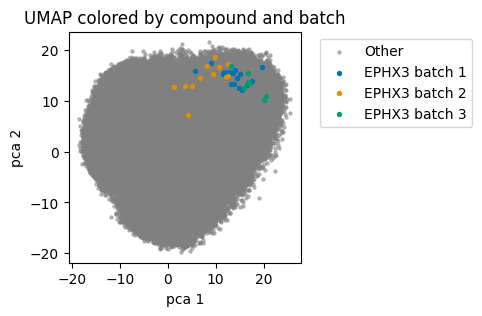

In [53]:
plot_umap_with_compound_and_batch(adata_before_correction, "compound", "batch", "EPHX3", dim_red="pca")

20
12
7



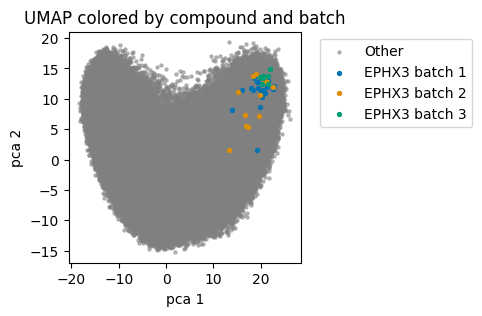

In [54]:
plot_umap_with_compound_and_batch(adata_after_correction, "compound", "batch", "EPHX3", dim_red="pca")

A4GALT

50
50
50



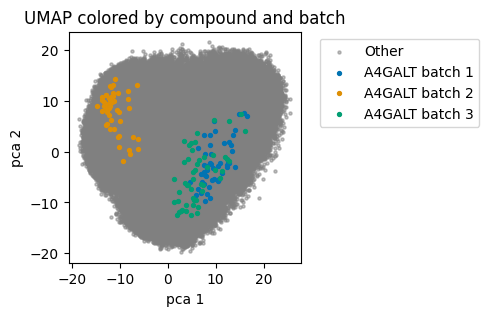

In [55]:
plot_umap_with_compound_and_batch(adata_before_correction, "compound", "batch", "A4GALT", dim_red="pca")

50
50
50



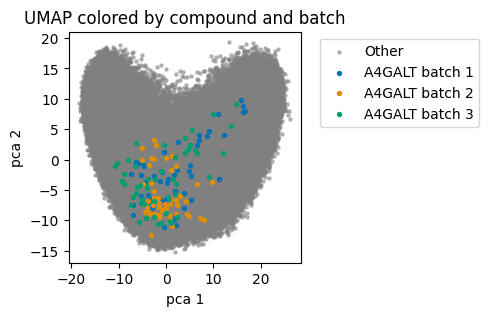

In [56]:
plot_umap_with_compound_and_batch(adata_after_correction, "compound", "batch", "A4GALT", dim_red="pca")

TSFM

35
50
10



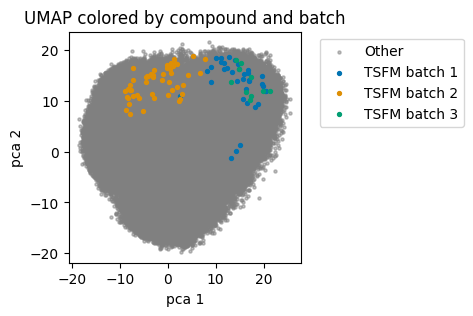

In [57]:
plot_umap_with_compound_and_batch(adata_before_correction, "compound", "batch", "TSFM", dim_red="pca")

35
50
10



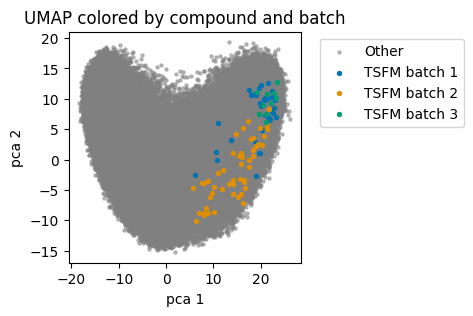

In [58]:
plot_umap_with_compound_and_batch(adata_after_correction, "compound", "batch", "TSFM", dim_red="pca")

SNTG2

21
20
13



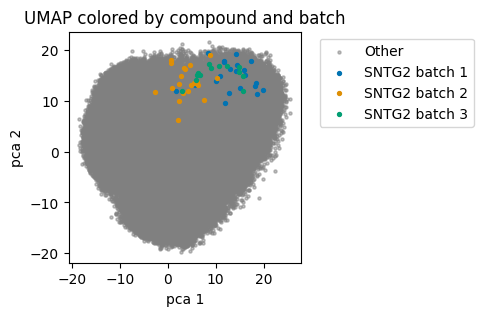

In [59]:
plot_umap_with_compound_and_batch(adata_before_correction, "compound", "batch", "SNTG2", dim_red="pca")

21
20
13



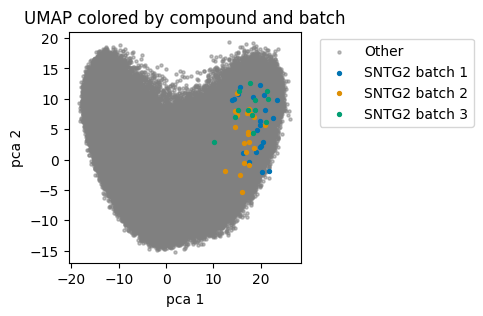

In [60]:
plot_umap_with_compound_and_batch(adata_after_correction, "compound", "batch", "SNTG2", dim_red="pca")

NAA15

24
32
25



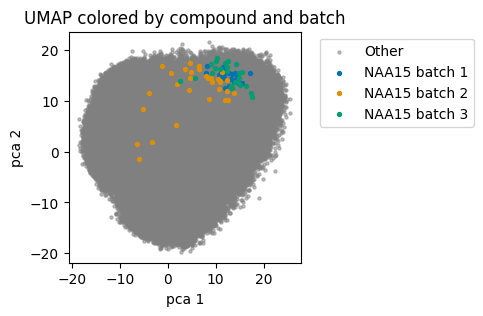

In [61]:
plot_umap_with_compound_and_batch(adata_before_correction, "compound", "batch", "NAA15", dim_red="pca")

24
32
25



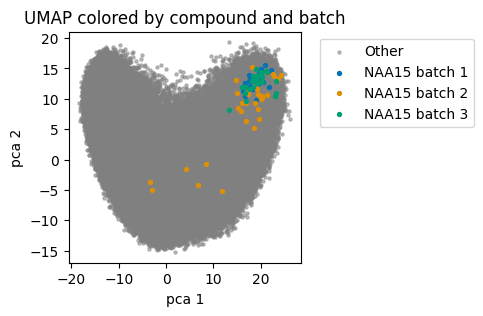

In [62]:
plot_umap_with_compound_and_batch(adata_after_correction, "compound", "batch", "NAA15", dim_red="pca")

NXF1

19
26
15



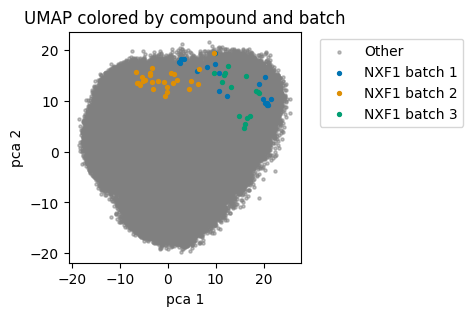

In [63]:
plot_umap_with_compound_and_batch(adata_before_correction, "compound", "batch", "NXF1", dim_red="pca")

19
26
15



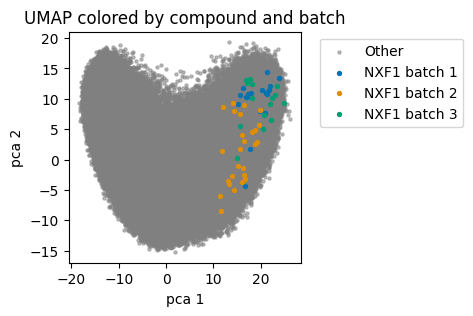

In [64]:
plot_umap_with_compound_and_batch(adata_after_correction, "compound", "batch", "NXF1", dim_red="pca")

GATAD2A

20
24
50



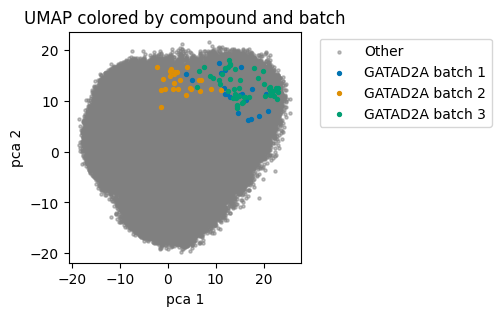

In [65]:
plot_umap_with_compound_and_batch(adata_before_correction, "compound", "batch", "GATAD2A", dim_red="pca")

20
24
50



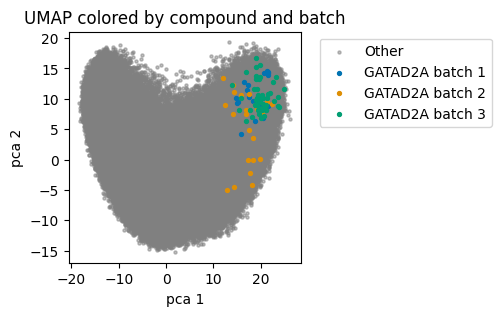

In [66]:
plot_umap_with_compound_and_batch(adata_after_correction, "compound", "batch", "GATAD2A", dim_red="pca")

TTN	

200
200
200



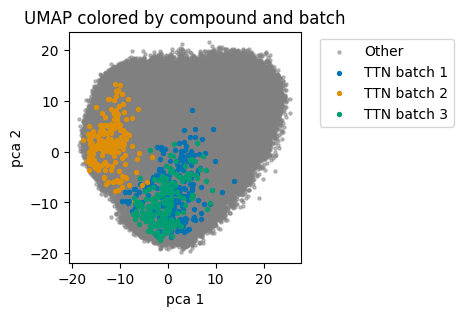

In [67]:
plot_umap_with_compound_and_batch(adata_before_correction, "compound", "batch", "TTN", dim_red="pca")

200
200
200



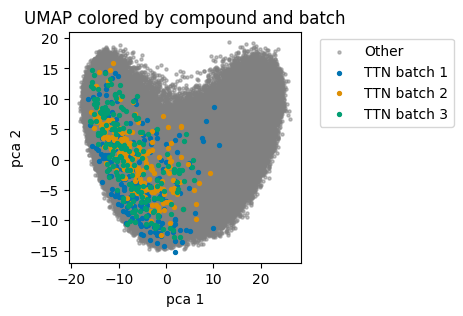

In [68]:
plot_umap_with_compound_and_batch(adata_after_correction, "compound", "batch", "TTN", dim_red="pca")

Louvain before and after correction 
- clusters you recover?
- after clustering corresponds to that mode of action
- Show correction data above and bio below 

NIPBL	

200
200
200



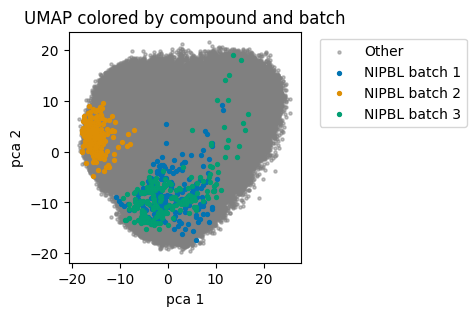

In [69]:
plot_umap_with_compound_and_batch(adata_before_correction, "compound", "batch", "NIPBL", dim_red="pca")

200
200
200



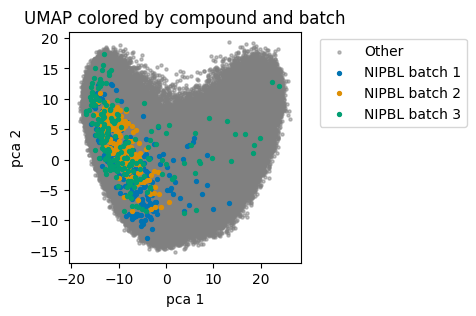

In [70]:
plot_umap_with_compound_and_batch(adata_after_correction, "compound", "batch", "NIPBL", dim_red="pca")

GRN	

200
200
200



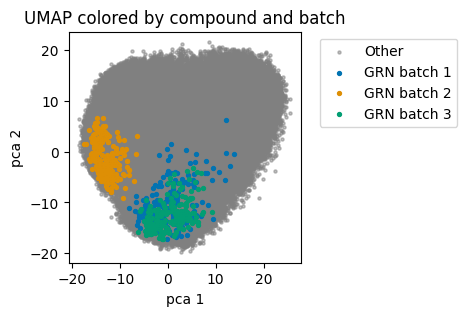

In [71]:
plot_umap_with_compound_and_batch(adata_before_correction, "compound", "batch", "GRN", dim_red="pca")

200
200
200



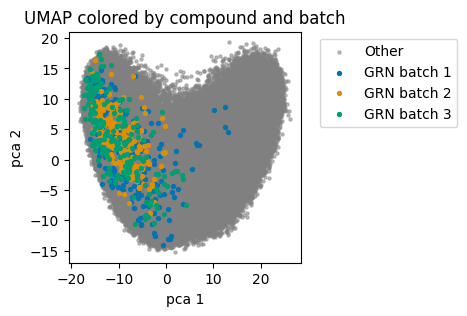

In [72]:
plot_umap_with_compound_and_batch(adata_after_correction, "compound", "batch", "GRN", dim_red="pca")

CYP27A1

200
200
200



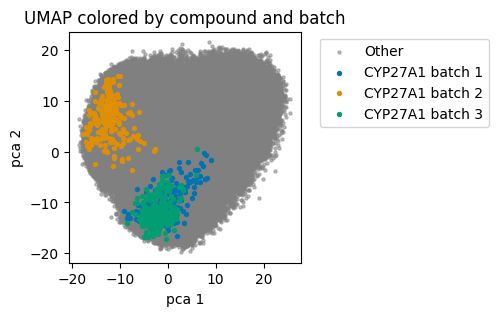

In [73]:
plot_umap_with_compound_and_batch(adata_before_correction, "compound", "batch", "CYP27A1", dim_red="pca")

200
200
200



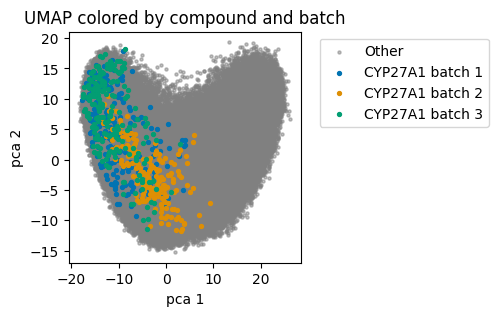

In [74]:
plot_umap_with_compound_and_batch(adata_after_correction, "compound", "batch", "CYP27A1", dim_red="pca")

Variable

200
200
200



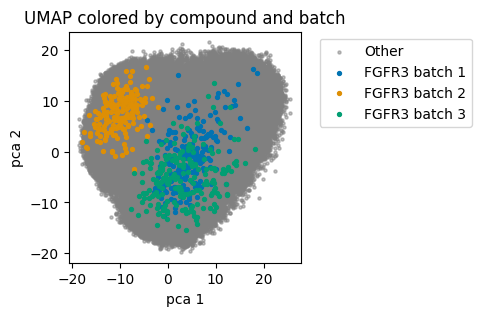

In [75]:
plot_umap_with_compound_and_batch(adata_before_correction, "compound", "batch", "FGFR3", dim_red="pca")

200
200
200



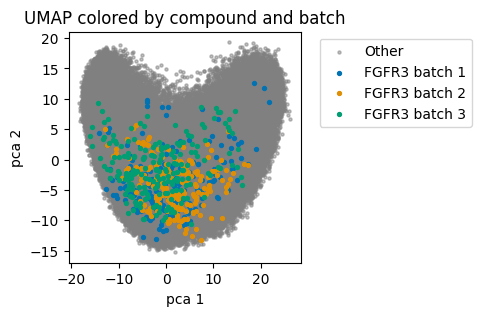

In [76]:
plot_umap_with_compound_and_batch(adata_after_correction, "compound", "batch", "FGFR3", dim_red="pca")

# LEIDEN cluster

In [77]:
FIGSIZE=(5,5)               
rcParams['figure.figsize']=FIGSIZE

In [78]:
sc.tl.leiden(adata_after_correction)

In [41]:
# sc.tl.leiden(adata_before_correction)

## Compute cluster purity

In [79]:
def compute_purity_scores(adata, metric='entropy'):
    """
    Compute batch and compound purity scores for each cluster.

    Args:
    adata (AnnData): Annotated data object containing cluster, batch, and compound annotations.
    metric (str): 'entropy' or 'gini' to specify the purity metric to use (default is 'entropy').

    Returns:
    pd.DataFrame: DataFrame containing purity scores for each cluster.
                  Columns: cluster, batch_purity, compound_purity
    """

    # Extract cluster, batch, and compound annotations
    clusters = adata.obs['leiden']
    batches = adata.obs['batch']
    compounds = adata.obs['compound']

    # Create a DataFrame to store purity scores
    purity_df = pd.DataFrame(columns=['cluster', 'batch', 'compound'])

    # Iterate over each cluster
    for cluster in clusters.unique():
        # Filter data for the current cluster
        cluster_indices = clusters[clusters == cluster].index
        cluster_batches = batches.loc[cluster_indices]
        cluster_compounds = compounds.loc[cluster_indices]

        # Compute batch distribution
        batch_counts = cluster_batches.value_counts(normalize=True)
        # Compute compound distribution
        compound_counts = cluster_compounds.value_counts(normalize=True)

        # Compute batch purity using specified metric
        if metric == 'entropy':
            batch_purity = -np.sum(batch_counts * np.log2(batch_counts))
        elif metric == 'gini':
            batch_purity = 1 - np.sum(batch_counts ** 2)
        else:
            raise ValueError("Invalid metric. Please choose 'entropy' or 'gini' for batch purity.")

        # Compute compound purity using specified metric
        if metric == 'entropy':
            compound_purity = -np.sum(compound_counts * np.log2(compound_counts))
        elif metric == 'gini':
            compound_purity = 1 - np.sum(compound_counts ** 2)
        else:
            raise ValueError("Invalid metric. Please choose 'entropy' or 'gini' for compound purity.")

        # Add purity scores to DataFrame
        purity_df = purity_df.append({'cluster': cluster, 'batch': batch_purity, 'compound': compound_purity},
                                     ignore_index=True)

    return purity_df

Entropy

In [80]:
compute_purity_scores(adata_after_correction, metric="entropy").mean(0)

cluster     1.847042e+14
batch       8.751791e-01
compound    9.116687e+00
dtype: float64

In [82]:
# compute_purity_scores(adata_before_correction, metric="entropy").mean(0)

In [81]:
compute_purity_scores(adata_after_correction, metric="gini").mean(0)

cluster     1.847042e+14
batch       3.830636e-01
compound    9.974047e-01
dtype: float64

In [83]:
# compute_purity_scores(adata_before_correction, metric="gini").mean(0)

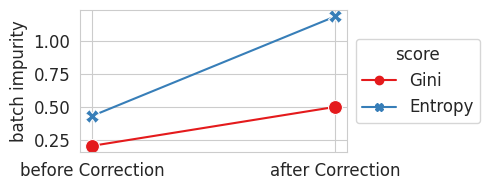

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# Impurity scores before and after correction
gini_scores = [2.065607e-01, 5.002087e-01]
entropy_scores = [4.326539e-01, 1.182906e+00]

# Labels for before and after correction
labels = ['before Correction', 'after Correction']

# Create a dataframe for seaborn
import pandas as pd
data = pd.DataFrame({
    'Impurity': ['Gini', 'Gini', 'Entropy', 'Entropy'],
    'Score': gini_scores + entropy_scores,
    'Correction': labels * 2
})

# Plot using seaborn
sns.set_style("whitegrid")
plt.figure(figsize=(5, 2))
sns.lineplot(x='Correction',
             y='Score', 
             hue='Impurity',
             style='Impurity',
             markers=True, 
             dashes=False,
             data=data,
             marker='o', markersize=10, palette="Set1")

# Adding labels and title
plt.xlabel('', fontsize=12)
plt.ylabel('batch impurity', fontsize=12)
# plt.title('Impurity Scores Before and After Batch Correction', fontsize=16)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12)
# plt.ylim(None, -0.3)
plt.legend(title='score', fontsize=12, title_fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()  # Ensures the legend doesn't get cut off
plt.savefig('/home/icb/alessandro.palma/environment/IMPA/IMPA/notebooks/cpg0000/plots/impurity_scores.svg', format='svg')  # Save as SVG image
plt.show()

